In [3]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
import matplotlib.cm as cm
import random
import matplotlib
import sys

from copy import deepcopy

from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

import semlinlens_v2bRprior as lens

#redirect to wherever pygravlens is stored
sys.path.insert(0,'/home/dilys/pygravlens/')
import pygravlens as gl

In [4]:
# preferences
plt.rcParams.update({'font.size': 14, 'text.usetex': False})
plt.rc('axes', labelsize=14)
folder = './'#folder for wherever you want to store the time delay data
root = 'mock_'

# set the assumed Hubble constant
cosmo = FlatLambdaCDM(H0=70,Om0=0.315)

# set the source and lens redshift
zlens = 0.3
zsrc = 2

# do not change below!
cosmo100 = FlatLambdaCDM(H0=100,Om0=0.315) # MCMC analysis written to output in terms of h, so this factor of H0 is needed
Dl = cosmo.comoving_distance(zlens)
Ds = cosmo.comoving_distance(zsrc)

In [18]:
# this function runs pygravlens and outputs the data in a similar format as the .dat files from lensmodel 
def writemock(imgarr,muarr,tdarr,sourcepos,outname):
    '''
    ###################################
    For N samples or "systems", 4 images each (quad):
    #imgarr: shape (N, 4, 2), coordinates in arcsec for each image
    #muarr: shape (N, 4), magnification for each image
    #tdarr: shape (N, 4), relative time delay in days for each image
    #sourcepos: shape (N, 2), coordinates in arcsec for the source of each system
    #outname: str, should include folder and file name "/home/dilys/file.dat"
    ###################################
    '''
    
    delta_pos = 0.003 # uncertainty in position [arcsec]
    delta_tauref = 0.01 #uncertainty in absolute time delay [day]

    f = open(outname,'w')
    f.write('1\n')
    f.write(f'0.0 0.0 {delta_pos}\n')
    f.write('0.0 10000.0\n')
    f.write('0.0 10000.0\n')
    f.write('0.0 10000.0\n')
    f.write('1\n')

    # determine number of images
    if len(imgarr) < 4:
        median_err = 3.0 #days
    elif len(imgarr) >= 4:
        median_err = 2.0 #days
        
    nimg = len(imgarr)

    f.write(f'{nimg}\n')

    for n in range(nimg):
        if tdarr[n]==0.0:
            choose_delta_tau = delta_tauref
        else:
            choose_delta_tau = median_err

        f.write('{:.6f} {:.6f} {:.6f} {:.3f} {:.6f} {:6f} {:.2f}\n'.format(
            imgarr[n][0], imgarr[n][1], muarr[n],
            delta_pos, 0.05*np.abs(muarr[n]), 
            tdarr[n].value, choose_delta_tau)
        )

    #f.write('{:.6f} {:.6f}\n'.format(source_pos[0], source_pos[1]))
    f.close()
    print('wrote file:',outname)
    return

number of planes: 1
maingrid: [[-2.5, 2.5, 20], [-2.5, 2.5, 20]]
galgrid: [1e-06, 2.5, 20, 20]


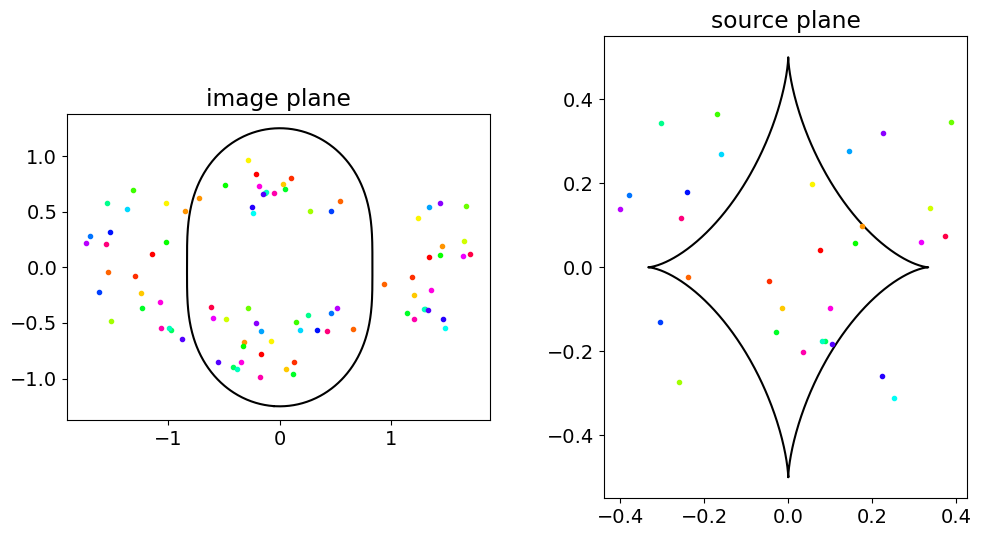

In [22]:
### get image positions, time delays, etc from pygravlens

# ENTER TRUTH #u - source x in arcsec, v - source y in arcsec, 
#eta - mass power law slope (1 isothermal), b - reparameterized Einstein radius, ec,es - quasi-cartesian ellipticity components
truth = [0.0,0.0,1.0,1.0,0.,0.] # u,v,eta,b,ec,es
gammac = 0.2
gammas = 0.
plane = gl.lensplane('ellpow',truth, Dl=Dl, gammac=gammac, gammas=gammas)
model = gl.lensmodel([plane], Ds=Ds)
model.info()
model.tile()

lim = 0.4 # extent of caustic in arcsec
num_lens = 30 #number of samples
source_pos = np.random.uniform(size=(num_lens,2), low=-lim,high=lim) #randomize source positions, limit value so get quads
    
imgarr, muarr, tdarr = model.findimg(source_pos)

model.plot(src=source_pos)

In [27]:
source_pos_save = []
index = 1
flags = []
for nn in range(0,num_lens):
    if len(imgarr[nn]) == 4:
        source_pos_save.append(source_pos[nn])
        outname = folder+root+str(index)+'.dat'
        #print(outname)
        writemock(imgarr[nn],muarr[nn],tdarr[nn],source_pos[nn], outname)
        index +=1
        flags.append(True)
    else:
        flags.append(False)
np.savetxt(folder+root+'source_pos.dat', source_pos_save)
N_quads = index

wrote file: ./mock_1.dat
wrote file: ./mock_2.dat
wrote file: ./mock_3.dat
wrote file: ./mock_4.dat
wrote file: ./mock_5.dat
wrote file: ./mock_6.dat
wrote file: ./mock_7.dat
wrote file: ./mock_8.dat
wrote file: ./mock_9.dat
wrote file: ./mock_10.dat
wrote file: ./mock_11.dat
wrote file: ./mock_12.dat
wrote file: ./mock_13.dat


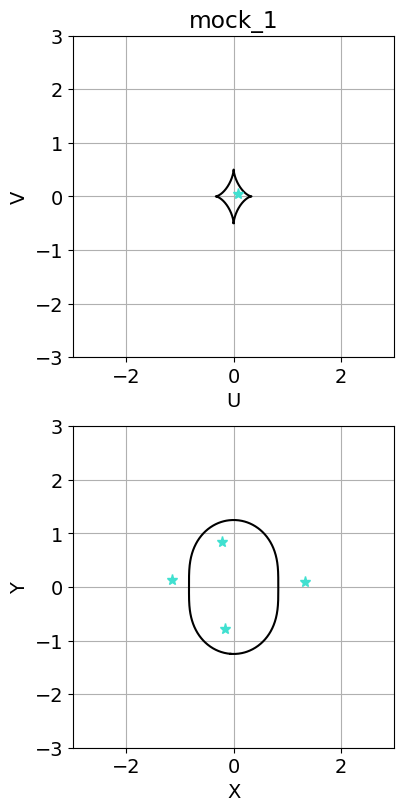

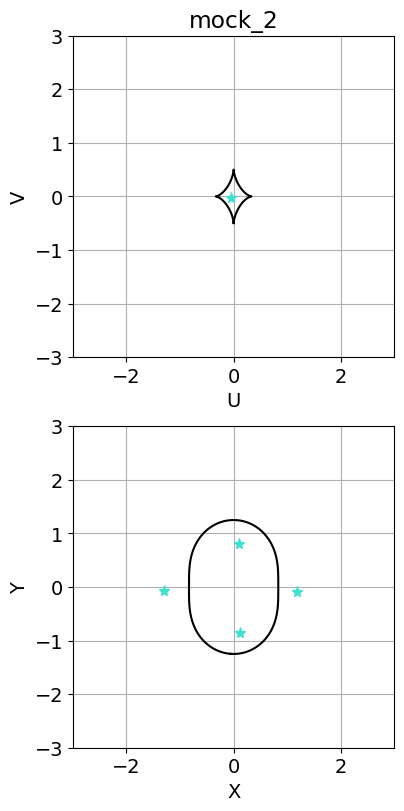

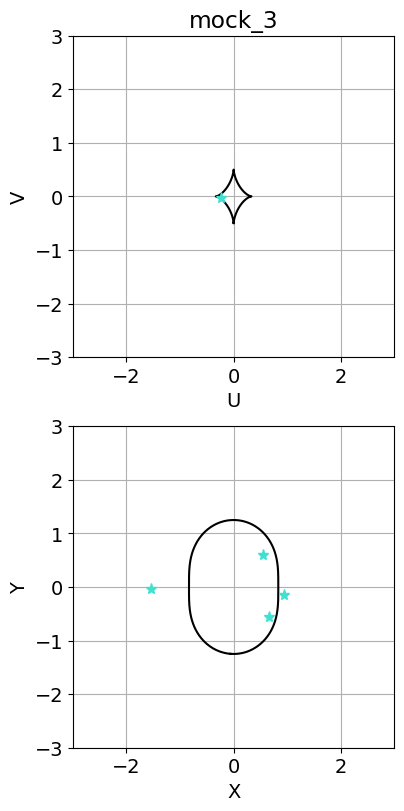

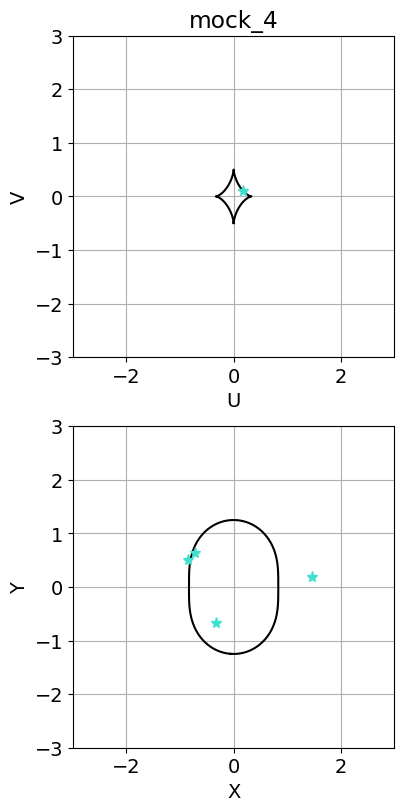

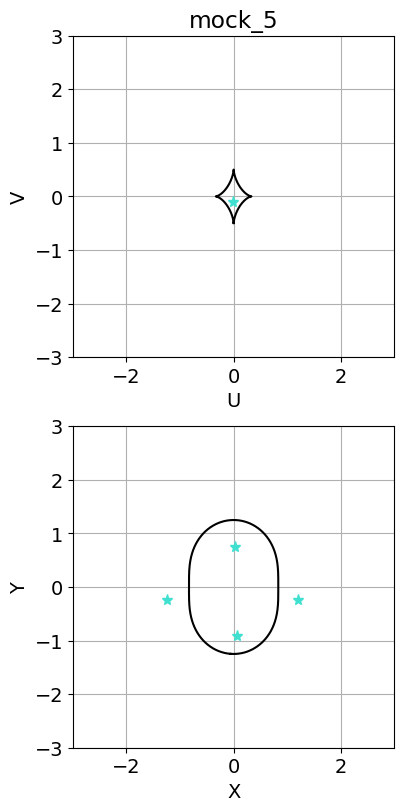

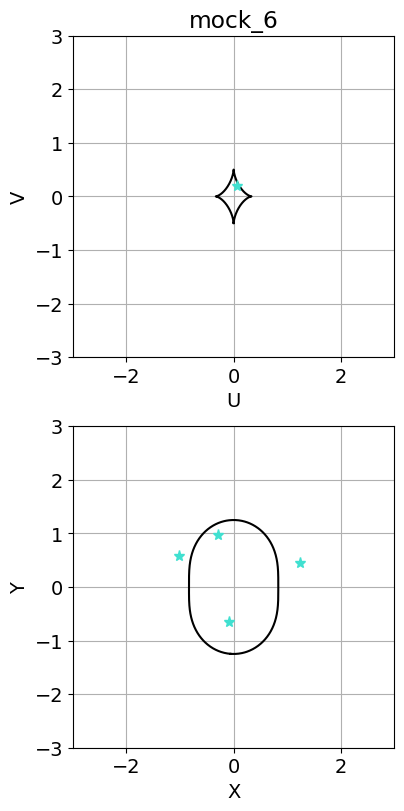

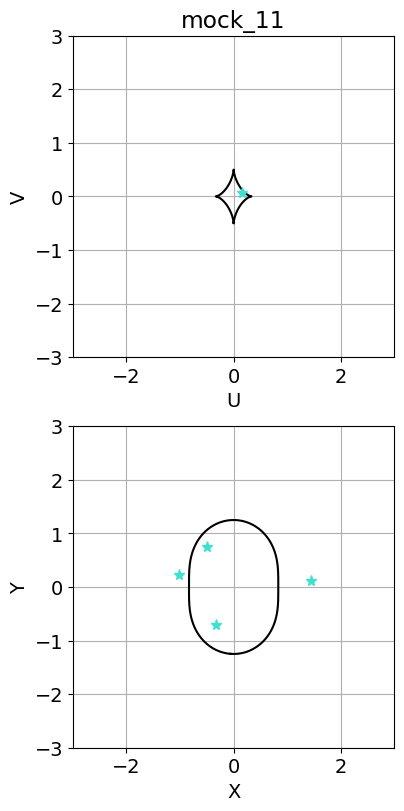

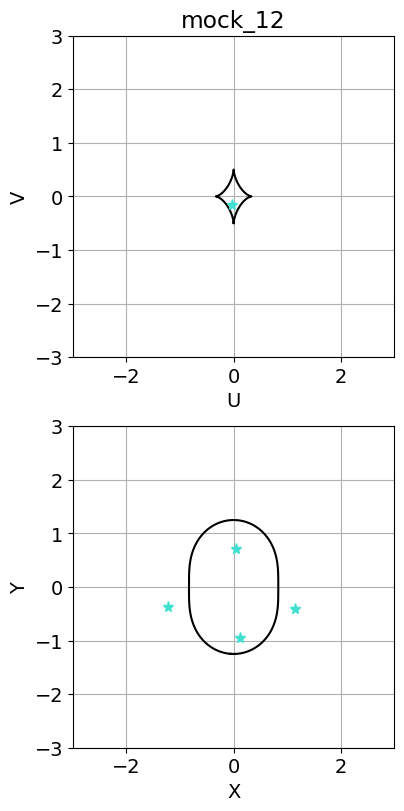

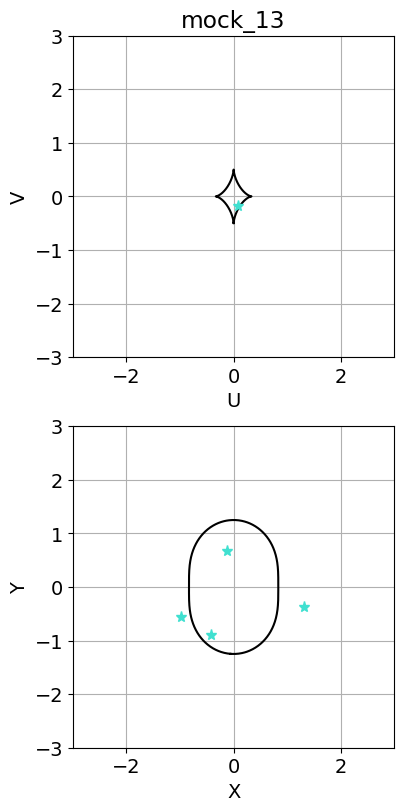

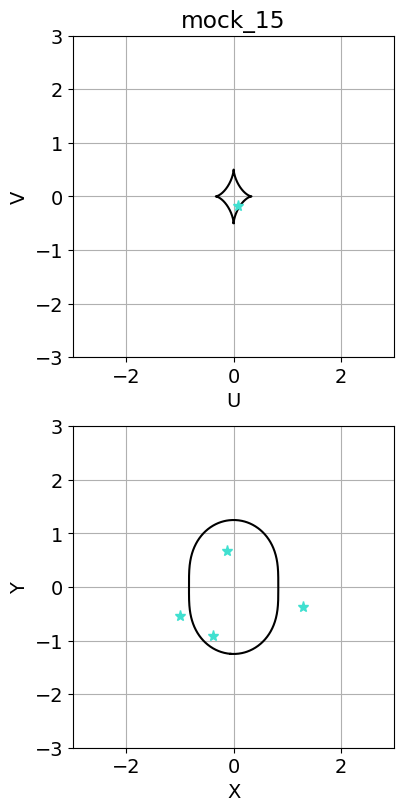

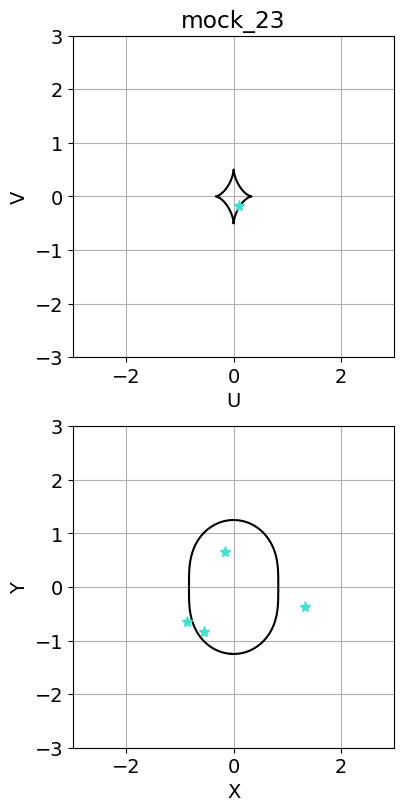

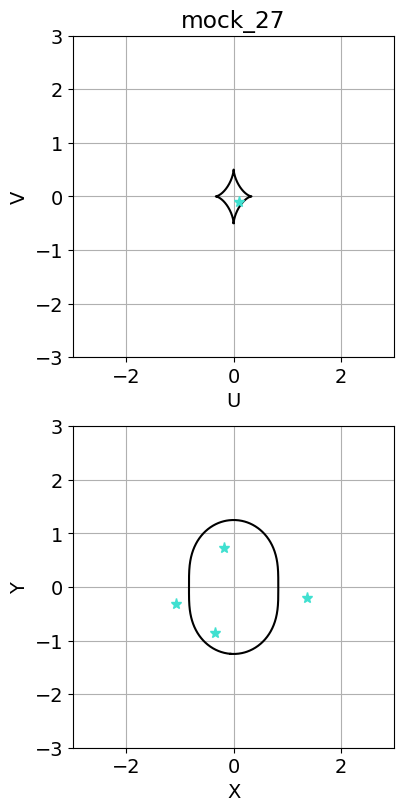

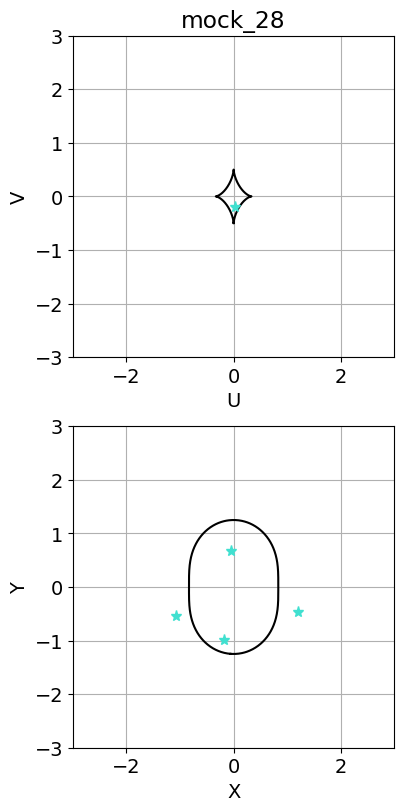

In [30]:
### PLOT MOCK LENS SYSTEM FROM PYGRAVLENS INFO

savefig=False
size=8

for nn in range(0,num_lens):
    if len(imgarr[nn]) == 4:
        outname = root+str(nn+1)

        fig, axes = plt.subplots(2,1, figsize=(4, 8), constrained_layout=True)
        #axx = fig.add_subplot(111)

        lim = 3.0
        axes[0].plot(model.caus[0][:,0], model.caus[0][:,1], color='black')
        axes[0].plot(source_pos[nn][0], source_pos[nn][1], '*', color='turquoise', markersize=size)
        axes[0].set_xlabel('U')
        axes[0].set_ylabel('V')
        axes[0].set_title(root+str(nn+1))

        axes[1].plot(model.crit[0][:,0], model.crit[0][:,1], color='black')
        axes[1].plot(imgarr[nn][:,0], imgarr[nn][:,1], '*', color='turquoise', markersize=size)
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Y')
        for n in range(0,2):
            axes[n].set_xlim([-lim,lim])
            axes[n].set_ylim([-lim,lim])
            axes[n].set_aspect('equal', adjustable='box')
            axes[n].grid()

        if savefig == True:
            plt.savefig(folder+'skymap-'+outname+'.pdf', bbox_inches='tight')

        #plt.close()